# main

In [1]:
import json
import requests
import popelines
import os
from main import fix_values, populating_vals, flatten, flatten_dupe_vals
from datetime import datetime

In [2]:
def fix_values(value, key, reset_key):
    if key == reset_key:
        new_list = []
        for x in value:
            value[x][f'{reset_key}_id'] = x
            new_list.append(value[x])
        return new_list
    else:
        return value

In [3]:
# read endpoint, returns a json file of the HTTP request
def read_endpoint(endpoint, headers_set, params_set=None):
    try:
        response = requests.get(endpoint, headers=headers_set, params=params_set)
        response_text = json.loads(response.text)
        response.raise_for_status()

    except requests.exceptions.HTTPError as err:
        print(err)

    return response_text

In [4]:
# # generate all experiments given a project id
# def generate_experiments(project_id, experiment_endpoint, experiment_headers, experiment_params):
#     # get all experiments from one project
#     j_exp = read_endpoint(endpoint=experiment_endpoint, headers_set=experiment_headers, params_set=experiment_params)

#     # loop for all experiments in this project
# #     experiment_id_list = []
# #     upload_exp_list = []
# #     for exp in j_exp:
# #         exp['project_id'] = project_id
# #         upload_exp_list.append(flatten(exp, {}, ''))
# #         experiment_id_list.append(exp['id'])
        
#     return upload_exp_list, experiment_id_list

In [5]:
# generate all projects within account
def generate_projects(project_endpoint, project_headers):
    # get all projects
    j_proj = read_endpoint(endpoint=project_endpoint, headers_set=project_headers)

    # store a list of project metadata
    return j_proj

# load all projects, get project_id's

In [6]:
gbq_key = os.environ.get('GOOGLE_ACCOUNT_CREDENTIALS')
pope = popelines.popeline(dataset_id='optimizely', service_key_file_loc=gbq_key, directory='.', verbose=False)

# Optimizely parameters
headers = {
    'Authorization': 'Bearer 2:EWAWmaXb4TgtYVU2VvwoEF-9UbJxBahkiFh1633_Oc9nmju7iJis',
    'Content-Type': 'application/json',
}

In [ ]:
project_endpoint = 'https://api.optimizely.com/v2/projects'

In [ ]:
all_projects = generate_projects(project_endpoint, headers)

In [ ]:
# pope.write_to_json(file_name='../uploads/projects.json', jayson=all_projects, mode='w')

In [ ]:
# pope.write_to_bq(table_name='projects', file_name='../uploads/projects.json', append=True, ignore_unknown_values=False, bq_schema_autodetect=False)
# print("Successfully uploaded all projects.")

In [ ]:
project_id_list = []
for project in all_projects:
    project_id_list.append((project['id']))

In [ ]:
# project_id_list


In [ ]:
# project_id_name = []
# for project in all_projects:
#     project_id_name.append((project['id'], project['name']))

In [ ]:
# project_id_name

# load experiments

In [7]:
experiment_endpoint = 'https://api.optimizely.com/v2/experiments'


In [8]:
# experiment_id_list = []
# all_exp_list = []

# for project_id in project_id_list:
    # params include project_id (required) and experiments pulling per each request (default only 25)
params = (
    ('project_id', 10429921250),
    ('per_page', 100),
) 


In [9]:
exp_list = read_endpoint(endpoint=experiment_endpoint, headers_set=headers, params_set=params)



In [10]:
experiment_id_list = []

In [11]:
exp_id_list = []
for exp in exp_list:
    exp_id_list.append(exp['id'])

In [12]:
experiment_id_list.extend(exp_id_list)

In [13]:
new = []

In [14]:
for e in exp_list:
    if e['id'] == 12900000180:
        new = e

In [15]:
exp=new

[{'actions': [{'changes': [],
    'page_id': 12913320166,
    'share_link': 'https://www.infusionsoft.com/lp/pro?optimizely_token=55f79c78a70a14b39e50dfccbdd0bd18aae4d29f44bb23785ad20033d995fdde&optimizely_x=12899560202&optimizely_x_audiences=&optimizely_preview_layer_ids=12924840378&optimizely_snippet=s3-10429921250#modal_infusionsoft_pro_demo'}],
  'archived': False,
  'name': 'Original',
  'status': 'active',
  'variation_id': 12899560202,
  'weight': 5000},
 {'actions': [{'changes': [{'async': False,
      'attributes': {'html': '<div class="mktoFieldDescriptor">\n  <div class="mktoFieldWrap mktoRequiredField">\n    <label for="mktoForm_3200_Email" class=""></label>\n    <div class="field-suggestion">\n      <input id="mktoForm_3200_Email" name="Email" placeholder="Email Address" maxlength="255" type="email" class="" required="required">\n      <div class="field-suggestion__dropdown">&nbsp;</div>\n    </div>\n  </div>\n</div>'},
      'css': {},
      'dependencies': [],
      'id'
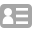

In [16]:
exp['variations']

# single layer table

In [ ]:
all_singles = []
nested_key_list = []
for k,v in exp.items():
    if isinstance(v, list):
        nested_key_list.append(k)

single_layer_experiment = {}    
for k,v in exp.items():
    if k not in nested_key_list:
        k = k.replace('-', '_')
        single_layer_experiment[k] = exp[k]
single_layer_experiment['upload_ts'] = str(datetime.now())


all_singles.append(flatten(single_layer_experiment, {}, ''))


In [ ]:
all_singles

# unnested metrics table

In [ ]:
metrics_table = []
for exp in exp_list:
    print(f"Processing experiment {exp['id']}")

    # single layer fields:
    nested_key_list = []
    for k,v in exp.items():
        if isinstance(v, list) or isinstance(v, dict):
            nested_key_list.append(k)

    single_layer_experiment = {}    
    for k,v in exp.items():
        if k not in nested_key_list:
            k = k.replace('-', '_')
            single_layer_experiment[k] = exp[k]
    single_layer_experiment['upload_ts'] = str(datetime.now())

    all_singles.append(flatten(single_layer_experiment, {}, ''))

    # nested part into separate tables:
    # metrics table:

    flattened_metric = []
    for element in exp['metrics']:
        flattened_metric.append(element)

    updated_metric = populating_vals(outer_dict=exp, inner_flattened_list=flattened_metric, destination_key='metrics')
    new_flattened_metric = flatten_dupe_vals(vals=updated_metric, key='metrics')

    metric_list = []
    for metric in new_flattened_metric:
        metric_dict = {}
        metric_dict['metrics_aggregator'] = metric['metrics_aggregator']
        if 'metrics_event_id' in metric.keys():
            metric_dict['metrics_event_id'] = metric['metrics_event_id']
        metric_dict['metrics_scope'] =  metric['metrics_scope']
        metric_dict['metrics_winning_direction'] = metric['metrics_winning_direction']
        metric_dict['experiment_id'] = exp['id']
        metric_dict['upload_ts'] = str(datetime.now())
        metric_list.append(metric_dict)
        
    metrics_table.extend(metric_list)
    

In [ ]:
# nested part into separate tables:
# metrics table:

flattened_metric = []
for element in exp['metrics']:
    flattened_metric.append(element)

updated_metric = populating_vals(outer_dict=exp, inner_flattened_list=flattened_metric, destination_key='metrics')
new_flattened_metric = flatten_dupe_vals(vals=updated_metric, key='metrics')

metric_list = []
for metric in new_flattened_metric:
    metric_dict = {}
    metric_dict['metrics_aggregator'] = metric['metrics_aggregator']
    if 'metrics_event_id' in metric.keys():
        metric_dict['metrics_event_id'] = metric['metrics_event_id']
    metric_dict['metrics_scope'] =  metric['metrics_scope']
    metric_dict['metrics_winning_direction'] = metric['metrics_winning_direction']
    metric_dict['experiment_id'] = exp['id']
    metric_dict['upload_ts'] = str(datetime.now())
    metric_list.append(metric_dict)

In [ ]:
metric_list

# unnested variations table

In [ ]:
variations_table = []
for exp in exp_list:
    print(f"Processing experiment {exp['id']}")

    variations = {}
    # for exp in exp_list:

    print(f"Processing experiment {exp['id']}")

    variations['experiment_id'] = exp['id']
    variations['variations'] = exp['variations']

    flattened_variations = []

    for var in exp['variations']:
        flattened_actions = []
        if len(var['actions']) > 0:
            for action in var['actions']:
                flattened_changes = []
                for element in action['changes']:
                    flattened_changes.append(element)
                # Replace old 'changes' with new 'flattened_changes'
                updated_changes = populating_vals(outer_dict=action, inner_flattened_list=flattened_changes, destination_key='changes')
                new_flattened_changes = flatten_dupe_vals(vals=updated_changes, key='changes')

                update_actions = populating_vals(outer_dict=var, inner_flattened_list=new_flattened_changes, destination_key='actions')
                flat = flatten_dupe_vals(vals=update_actions, key='actions')
                flattened_actions.extend(flat)

        else:
            other_flat = {}
            for k,v in var.items():
                if k != 'actions':
                    other_flat['actions'] = []
                    other_flat[k] = v
            flat = [other_flat]
            flattened_actions.extend(flat)

        update_variations = populating_vals(outer_dict=variations, inner_flattened_list=flattened_actions, destination_key='variations')
        flattened_variations.extend(flatten_dupe_vals(vals=update_variations, key='variations'))

    variations_table.extend(flattened_variations)
    
    

In [17]:
variations = {}
# for exp in exp_list:

print(f"Processing experiment {exp['id']}")

variations['experiment_id'] = exp['id']
variations['variations'] = exp['variations']



Processing experiment 12900000180


[{'actions': [{'changes': [],
    'page_id': 12913320166,
    'share_link': 'https://www.infusionsoft.com/lp/pro?optimizely_token=55f79c78a70a14b39e50dfccbdd0bd18aae4d29f44bb23785ad20033d995fdde&optimizely_x=12899560202&optimizely_x_audiences=&optimizely_preview_layer_ids=12924840378&optimizely_snippet=s3-10429921250#modal_infusionsoft_pro_demo'}],
  'archived': False,
  'name': 'Original',
  'status': 'active',
  'variation_id': 12899560202,
  'weight': 5000},
 {'actions': [{'changes': [{'async': False,
      'attributes': {'html': '<div class="mktoFieldDescriptor">\n  <div class="mktoFieldWrap mktoRequiredField">\n    <label for="mktoForm_3200_Email" class=""></label>\n    <div class="field-suggestion">\n      <input id="mktoForm_3200_Email" name="Email" placeholder="Email Address" maxlength="255" type="email" class="" required="required">\n      <div class="field-suggestion__dropdown">&nbsp;</div>\n    </div>\n  </div>\n</div>'},
      'css': {},
      'dependencies': [],
      'id'
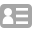

In [18]:
exp['variations']

In [28]:
flattened_variations = []

for var in exp['variations']:
    flattened_actions = []

    if len(var['actions']) > 0:
        
        for action in var['actions']:
            
            flattened_changes = []
            
            if action['changes'] != []:
                for element in action['changes']:
                    flattened_changes.append(element)
                # Replace old 'changes' with new 'flattened_changes'
                updated_changes = populating_vals(outer_dict=action, inner_flattened_list=flattened_changes, destination_key='changes')
                new_flattened_changes = flatten_dupe_vals(vals=updated_changes, key='changes')

                update_actions = populating_vals(outer_dict=var, inner_flattened_list=new_flattened_changes, destination_key='actions')
                flat = flatten_dupe_vals(vals=update_actions, key='actions')
                flattened_actions.extend(flat)
                
            else:
                new_actions = flatten_dupe_vals(vals=var, key='actions')
                flattened_actions.extend(new_actions)


    update_variations = populating_vals(outer_dict=variations, inner_flattened_list=flattened_actions, destination_key='variations')
    flattened_variations.extend(flatten_dupe_vals(vals=update_variations, key='variations'))

    
    

[{'experiment_id': 12900000180,
  'variations_actions_page_id': 12913320166,
  'variations_actions_share_link': 'https://www.infusionsoft.com/lp/pro?optimizely_token=55f79c78a70a14b39e50dfccbdd0bd18aae4d29f44bb23785ad20033d995fdde&optimizely_x=12899560202&optimizely_x_audiences=&optimizely_preview_layer_ids=12924840378&optimizely_snippet=s3-10429921250#modal_infusionsoft_pro_demo',
  'variations_archived': False,
  'variations_name': 'Original',
  'variations_status': 'active',
  'variations_variation_id': 12899560202,
  'variations_weight': 5000},
 {'experiment_id': 12900000180,
  'variations_actions_changes_async': False,
  'variations_actions_changes_attributes_html': '<div class="mktoFieldDescriptor">\n  <div class="mktoFieldWrap mktoRequiredField">\n    <label for="mktoForm_3200_Email" class=""></label>\n    <div class="field-suggestion">\n      <input id="mktoForm_3200_Email" name="Email" placeholder="Email Address" maxlength="255" type="email" class="" required="required">\n    
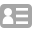

In [31]:
flattened_variations

### Testing flatten_dupe_vals

In [ ]:
# new_flattened_test = flatten_dupe_vals(vals=test, key='actions')
vals = test
key = 'actions'

In [ ]:
duped_results = []
for element in vals[key]:
    ts_dict = populating_vals(outer_dict=vals, inner_flattened_list=element, destination_key=key)
    duped_results.append(ts_dict)



In [ ]:
duped_results

In [ ]:
flattened_results = []
for element in duped_results:
    flattened_results.append(flatten(element, {}, ''))

In [ ]:
flatten(duped_results[0], {}, '')

### It is the flatten function that f*cked things up

In [ ]:
duped_results[0]

In [ ]:
# corrected flatten
def flatten(jayson, acc, prefix):
    if isinstance(jayson, dict):
        for k,v in jayson.items():
            if prefix:
                prefix_k = prefix + "_" + k
            else: 
                prefix_k = k
            prefix_k = prefix_k.replace('-', '_')
            
            if isinstance(v, dict):
                flatten(v, acc, prefix_k)
            elif isinstance(v, list):
                if v != []:
                    for j in v:
                        flatten(j, acc, prefix_k)
                else:
                    acc[prefix_k] = v
            else:
                acc[prefix_k] = v
        return acc 
    else:
        return acc

In [ ]:
flatten(duped_results[0], {}, '')

### Thus fixing the missing changes issue!

In [ ]:
flattened_variations = []

for var in expanded_exp['variations']:
    flattened_actions = []
    for action in var['actions']:
        print(action)
#         flattened_changes = []
#         for element in action['changes']:
#             flattened_changes.append(element)

        # Replace old 'timeseries' with new 'flattened_timeseries'
#         updated_changes = populating_vals(outer_dict=action, inner_flattened_list=flattened_changes, destination_key='changes')
#         new_flattened_changes = flatten_dupe_vals(vals=updated_changes, key='changes')

#     update_actions = populating_vals(outer_dict=var, inner_flattened_list=new_flattened_changes, destination_key='actions')
#     flattened_actions.extend(flatten_dupe_vals(vals=update_actions, key='actions'))  

# update_variations = populating_vals(outer_dict=expanded_exp, inner_flattened_list=flattened_actions, destination_key='variations')
# flattened_variations.extend(flatten_dupe_vals(vals=update_variations, key='variations'))

# expanded_variations = flattened_variations

In [ ]:
flattened_changes

# results timeseries

In [ ]:
# experiment_id_list

In [ ]:
# example of no results
# result_endpoint = 'https://api.optimizely.com/v2/experiments/11479333433/timeseries'
# example of normal time series
result_endpoint = 'https://api.optimizely.com/v2/experiments/11477653122/timeseries'
# example of 
# result_endpoint = f'https://api.optimizely.com/v2/experiments/{experiment_id}/timeseries'



In [ ]:
response_ts = requests.get(result_endpoint, headers=headers)

# if '' then the experiment has not started yet
if response_ts.text == '':
    j_ts = {'experiment_id': experiment_id}
elif 'bad' in response_ts.text:
    j_ts = {'experiment_id': experiment_id}
else:
    j_ts = json.loads(response_ts.text)

new_j_ts = pope.fix_json_values(callback=fix_values, obj=j_ts, reset_key='results')


In [ ]:
flattened_j_ts = []

flattened_metrics = []
for metric in new_j_ts['metrics']:
    if 'results' in metric.keys():
        for ts in metric['results']:
            flattened_timeseries = []
            for element in ts['timeseries']:
                element['upload_ts'] = str(datetime.now())
                flattened_timeseries.append(flatten(element, {}, ''))

            # Replace old 'timeseries' with new 'flattened_timeseries'
            updated_results = populating_vals(outer_dict=ts, inner_flattened_list=flattened_timeseries, destination_key='timeseries')
            flattened_results = flatten_dupe_vals(vals=updated_results, key='timeseries')

        # Replace old 'metrics' with new 'flattened_results'
        update_metrics = populating_vals(outer_dict=metric, inner_flattened_list=flattened_results, destination_key='results')
        flattened_metrics.extend(flatten_dupe_vals(vals=update_metrics, key='results'))

    else:
        flattened_metrics = [flatten(new_j_ts, {}, '')]

update_new_j_ts = populating_vals(outer_dict=new_j_ts, inner_flattened_list=flattened_metrics, destination_key='metrics')
flattened_j_ts.extend(flatten_dupe_vals(vals=update_new_j_ts, key='metrics'))



In [ ]:
j_ts

In [ ]:
flattened_j_ts

In [ ]:
new_j_ts['metrics']


            

# testing

In [ ]:
from generate_original import read_endpoint, generate_projects, generate_experiments

In [ ]:
if not os.environ.get('GOOGLE_ACCOUNT_CREDENTIALS'):
    os.environ['GOOGLE_ACCOUNT_CREDENTIALS'] = '/home/engineering/keyfile.json'
gbq_key = os.environ.get('GOOGLE_ACCOUNT_CREDENTIALS')

############################################### Instantiating Popelines #######################################
pope = popelines.popeline(dataset_id='optimizely', service_key_file_loc=gbq_key, directory='.', verbose=False)

# Optimizely parameters
headers = {
    'Authorization': 'Bearer 2:EWAWmaXb4TgtYVU2VvwoEF-9UbJxBahkiFh1633_Oc9nmju7iJis',
}

# endpoints
project_endpoint = 'https://api.optimizely.com/v2/projects'
experiment_endpoint = 'https://api.optimizely.com/v2/experiments'


############################################### generate and upload all projects ##############################
all_projects = generate_projects(project_endpoint, headers)
for project in all_projects:
    project['upload_ts'] = str(datetime.now())

# upload projects 
pope.write_to_json(file_name='../uploads/projects.json', jayson=all_projects, mode='w')
pope.write_to_bq(table_name='projects', file_name='../uploads/projects.json', append=True, ignore_unknown_values=False, bq_schema_autodetect=False)


############################################### generate and upload all experiments ##############################
# get a list of project_id from all_projects
project_id_list = []
for project in all_projects:
    project_id_list.append(project['id'])

# to accumulate all experiment_id, for 
experiment_id_list = []
origin_single_table = []
origin_metrics_table = []
origin_variations_table = []

# loop over all project_id_list to get experiments within each project
for project_id in project_id_list:
    # params include project_id (required) and experiments pulling per each request (default only 25)
    params = (
        ('project_id', project_id),
        ('per_page', 100),
    ) 

    exp_list = read_endpoint(endpoint=experiment_endpoint, headers_set=headers, params_set=params)
    exp_id_list = []
    for exp in exp_list:
        exp_id_list.append(exp['id'])
    experiment_id_list.extend(exp_id_list)

    all_singles, metrics_table, variations_table = generate_experiments(exp_list)
    origin_single_table.extend(all_singles)
    origin_metrics_table.extend(metrics_table)
    origin_variations_table.extend(variations_table)

pope.write_to_json(file_name='../uploads/origin_experiments_single_fields.json', jayson=origin_single_table, mode='w')  
pope.write_to_json(file_name='../uploads/origin_experiments_metrics_table.json', jayson=origin_metrics_table, mode='w')
pope.write_to_json(file_name='../uploads/origin_experiments_variations_table.json', jayson=origin_variations_table, mode='w')





In [ ]:
for e in origin_single_table:
    if e['id'] == 12900000180:
        print(e)

In [ ]:
for m in origin_metrics_table:
    if m['experiment_id'] == 12900000180:
        print(m)

In [ ]:
l = []
for v in origin_variations_table:
    if v['experiment_id'] == 12900000180:
        l.append(v['variations_name'])

In [ ]:
l

In [ ]:
exp_list

In [ ]:
for e in exp_list:
    print(e['id'])

In [ ]:
exp

In [ ]:
variations = {}
variations['experiment_id'] = exp['id']
variations['variations'] = exp['variations']

flattened_variations = []

for var in exp['variations']:
    flattened_actions = []
    if len(var['actions']) > 0:
        for action in var['actions']:
            flattened_changes = []
            for element in action['changes']:
                flattened_changes.append(element)
            # Replace old 'changes' with new 'flattened_changes'
            updated_changes = populating_vals(outer_dict=action, inner_flattened_list=flattened_changes, destination_key='changes')
            new_flattened_changes = flatten_dupe_vals(vals=updated_changes, key='changes')

        update_actions = populating_vals(outer_dict=var, inner_flattened_list=new_flattened_changes, destination_key='actions')
        flat = flatten_dupe_vals(vals=update_actions, key='actions')
        
        flattened_actions.extend(flat)

    else:
        other_flat = {}
        for k,v in var.items():
            if k != 'actions':
                other_flat['actions'] = []
                other_flat[k] = v
        flat = [other_flat]
    
        flattened_actions.extend(flat)

    update_variations = populating_vals(outer_dict=variations, inner_flattened_list=flattened_actions, destination_key='variations')
    flattened_variations.extend(flatten_dupe_vals(vals=update_variations, key='variations'))
    

In [ ]:
len(flattened_variations)

In [ ]:
for v in flattened_variations:
    print(v['variations_variation_id'])

In [ ]:
for v in flattened_variations:
    print(v['variations_name'])

In [ ]:
for v in flattened_variations:
    if 'variations_actions_changes_id' in v.keys():
        print(v['variations_actions_changes_id'])